In [1]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

%matplotlib inline

Let's define a function to perform [AdaM](https://arxiv.org/abs/1412.6980) updates...

In [2]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

## 0.  Overview

This notebook serves as a short tutorial on approximate inference, using a 2D Gaussian mixture for demonstrations.  First I cover [stochastic gradient variational Bayes](https://arxiv.org/abs/1312.6114) and then [Stein variational gradient descent](https://arxiv.org/abs/1608.04471).  Finally, I combine the two to demonstrate [Stein mixture approximations](http://approximateinference.org/2017/accepted/NalisnickSmyth2017.pdf).  

## 1.  Simulated Posterior: Mixture Density

We are going to demonstrate all techniques on a simulated posterior.  As posteriors in the wild are often multimodal, we'll use a Gaussian mixture as our demonstration...

In [3]:
# Gaussian
def gaussPdf(x, params):
    # params: {'mu': mean, 'sigma': standard dev.}
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

# 2D Gaussian Mixture
def logGaussMixPDF(x, params):
    # params: {'pi': list of weights, 'mu': list of means, 'sigma': list of standard devs}
    return np.log(params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]}))

Let's choose the parameters and plot the density...

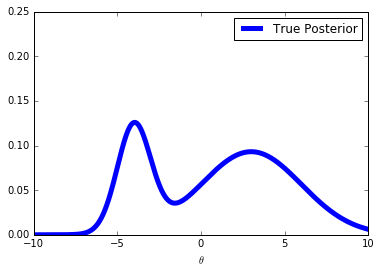

In [4]:
true_posterior_params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

plt.figure()

theta_grid = np.linspace(-10, 10, 1000)

probs_true = [np.exp(logGaussMixPDF(z, true_posterior_params)) for z in theta_grid]
plt.plot(theta_grid, probs_true, 'b-', linewidth=5, label="True Posterior")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

## 2.  Variational Inference via the ELBO

Now let's fit a Gaussian approximation--$q(\boldsymbol{\theta};\boldsymbol{\phi}) \ = \ \text{N}(\boldsymbol{\mu}_{\boldsymbol{\phi}}, \boldsymbol{\sigma}_{\boldsymbol{\phi}})$--using the [*Evidence Lower Bound* (ELBO)](http://www.umiacs.umd.edu/~xyang35/files/understanding-variational-lower.pdf): $$ \log p(x) = \mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \mathbb{H}_{q}[\boldsymbol{\theta}] + \text{KLD}[q(\boldsymbol{\theta}) || p(\boldsymbol{\theta} | \mathbf{X})] \ge \mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \mathbb{H}_{q}[\boldsymbol{\theta}].$$

We'll perform fully gradient-based optimization.  Differentiating we have... $$ \frac{\partial}{\partial \boldsymbol{\phi}} \mathcal{L}_{\text{ELBO}} =  \frac{\partial}{\partial \boldsymbol{\phi}} \mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] + \frac{\partial}{\partial \boldsymbol{\phi}} \mathbb{H}_{q}[\boldsymbol{\theta}].$$

Furthermore, so that we don't have to compute the above expectation by hand, we'll use a Monte Carlo (MC) approximation: $$\mathbb{E}_{q(\boldsymbol{\theta})}[ \log p(\mathbf{X}, \boldsymbol{\theta})] \approx \frac{1}{S} \sum_{s} \log p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{s})  $$ where $\hat{\boldsymbol{\theta}}_{s} \sim q(\boldsymbol{\theta})$.  The resulting gradient is then $$ \frac{\partial}{\partial \boldsymbol{\phi}} \frac{1}{S} \sum_{s} \log p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{s}) = \frac{1}{S} \sum_{s} \frac{\partial}{\partial \hat{\boldsymbol{\theta}}_{s}} \log p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{s}) \frac{\partial \hat{\boldsymbol{\theta}}_{s}}{\partial \boldsymbol{\phi}}.$$  More importantly, we'll also use MC techniques when the expectations don't have analytical solutions (like in the case of Bayesian neural networks).

The first step will be to get the necessary gradient terms via Autograd...

In [5]:
# Entropy of Gaussian
def gaussEntropy(log_sigma):
    return .5 * (np.log(2*np.pi*np.e) + 2.*log_sigma)

# Function for sampling from Gaussian location-scale form
def sample_from_Gauss(mu, log_sigma):
    e = np.random.normal()
    return mu + np.exp(log_sigma) * e, e


### GET DERIVATIVES ###

# d log p(X, \theta) / d \theta
logModel = logGaussMixPDF
dLogModel_dTheta = grad(logModel)

# d theta / d log_sigma
### we'll implement this ourselves

# d entropy / d log_sigma
dEntropy_dLogSigma = grad(gaussEntropy)

Now lets initialize the variational parameters and optimize the ELBO...

In [6]:
### INIT VARIATIONAL PARAMS 
phi = {'mu':-5., 'log_sigma':0.}


### ELBO OPTIMIZATION
maxEpochs = 500
learning_rate = .1
adam_values = {'mu':{'mean': 0., 'var': 0., 't': 0}, 'log_sigma':{'mean': 0., 'var': 0., 't': 0}}
n_samples = 10

for epochIdx in range(maxEpochs):
    
    elbo_grad_mu, elbo_grad_log_sigma = 0., 0.
    for s in range(n_samples):
        
        theta_hat, rand_seed = sample_from_Gauss(phi['mu'], phi['log_sigma'])
        dModel_dTheta = dLogModel_dTheta(theta_hat, true_posterior_params)
        
        elbo_grad_mu += 1./n_samples * dModel_dTheta * 1.
        elbo_grad_log_sigma += 1./n_samples * dModel_dTheta * rand_seed * np.exp(phi['log_sigma'])
        
    elbo_grad_log_sigma += dEntropy_dLogSigma(phi['log_sigma'])
        
    phi['mu'] += get_AdaM_update(learning_rate, elbo_grad_mu, adam_values['mu'])  
    phi['log_sigma'] += get_AdaM_update(learning_rate, elbo_grad_log_sigma, adam_values['log_sigma']) 
        
print phi

{'mu': 1.6965012925866934, 'log_sigma': 1.3672309018120739}


Let's visualize the results...

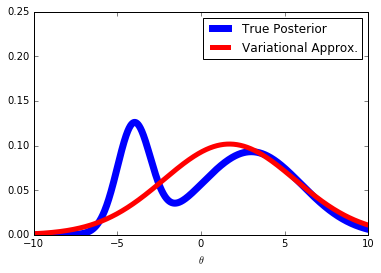

In [7]:
probs_approx = [gaussPdf(z, {'mu':phi['mu'], 'sigma':np.exp(phi['log_sigma'])}) for z in theta_grid] 
    
plt.figure()

plt.plot(theta_grid, probs_true, 'b-', linewidth=7, label="True Posterior")
plt.plot(theta_grid, probs_approx, '-r', linewidth=5, label="Variational Approx.")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

## 3.  Variational Inference via Stein Variational Gradient Descent (SVGD)
##### by Qiang Liu, Dilin Wang (https://arxiv.org/abs/1608.04471)

Particles explore the posterior according to the following iterative algorithm:
$$ \boldsymbol{\theta}_{k}^{t+1} \leftarrow \boldsymbol{\theta}_{k}^{t} + \epsilon \ \hat{\boldsymbol{\psi}}[\boldsymbol{\theta}_{k}^{t}] \  \text{  where  } \  \hat{\boldsymbol{\psi}}[\cdot] = \frac{1}{K} \sum_{j=1}^{K} k(\boldsymbol{\theta}_{j}, \boldsymbol{\theta}_{k}) \nabla_{\boldsymbol{\theta}_{j}} \log p(\mathbf{X}, \boldsymbol{\theta}_{j}) + \nabla_{\boldsymbol{\theta}_{j}} k(\boldsymbol{\theta}_{j}, \boldsymbol{\theta}_{k})$$
where $k(\cdot, \cdot)$ is a valid kernel and $\epsilon$ is a step-size.  Let's implement a kernel and the operator $\hat{\boldsymbol{\psi}}[\boldsymbol{\theta}_{k}^{t}]$ below...

In [8]:
# Kernel: Radial Basis Function 
def rbf(x1, x2, params={'lengthScale': 5.}):
    return np.exp((-.5/params['lengthScale']) * np.sum((x1-x2)**2))


# SVGD Operator 
def steinOp(theta_particles, dLogModel, kernel, dKernel):
    K = len(theta_particles)
    
    # precompute model derivative w.r.t. each particle
    dModel_dThetas = [0.] * K
    for k in range(K):
        dModel_dThetas[k] = dLogModel(theta_particles[k], true_posterior_params)
    
    # compute each particle's update
    particle_updates = [0.] * K
    for k in range(K):
        for j in range(K):
            particle_updates[k] += kernel(theta_particles[j], theta_particles[k]) * dModel_dThetas[j] \
                                    + dKernel(theta_particles[j], theta_particles[k])
        particle_updates[k] /= K
        
    return particle_updates

Now lets initialize the particles and optimize...

In [26]:
### INIT VARIATIONAL PARTICLES 
n_particles = 10
theta_particles = [np.random.normal(loc=-5.) for k in range(n_particles)]


### STEIN VARIATIONAL GRADIENT DESCENT
maxEpochs = 500
learning_rate = .1
adam_values = [{'mean': 0., 'var': 0., 't': 0} for k in range(n_particles)]

for epochIdx in range(maxEpochs):
    
    particle_updates = steinOp(theta_particles, dLogModel_dTheta, rbf, grad(rbf))
    
    for k in range(n_particles):
        theta_particles[k] += get_AdaM_update(learning_rate, particle_updates[k], adam_values[k])  
        
print theta_particles

[-5.3057184820306036, -3.1027094568349907, 7.3623730115066905, 1.441007800865858, 4.9261213602095788, 2.6783200261125835, -0.074978801932567077, -4.3423382344738979, -3.1695897672673481, 3.944173729000001]


Let's visualize the results...

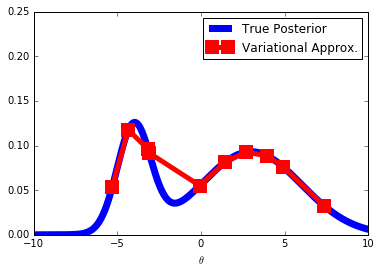

In [27]:
theta_particles.sort()
probs_approx = [np.exp(logModel(z, true_posterior_params)) for z in theta_particles]   
    
plt.figure()

plt.plot(theta_grid, probs_true, 'b-', linewidth=7, label="True Posterior")
plt.plot(theta_particles, probs_approx, 'sr-', markersize=14, mew=0, linewidth=5, label="Variational Approx.")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()

## 4.  Variational Inference via Stein Mixtures

Lastly, we now propose a variational inference algorithm that combines the ELBO (#2) and SVGD (#3).  Essentailly, we are going to run SVGD on the parameters of the variational approximation instead of on the original generative model parameter space ($\boldsymbol{\theta}$).  Mathematically, the *variational* model can be specified as: $$ \boldsymbol{\phi} \sim \frac{1}{K} \sum_{k} \delta[\boldsymbol{\phi}_{k}], \ \ \ \boldsymbol{\theta} \sim q(\boldsymbol{\theta} | \boldsymbol{\phi}) \ \ \text{ thus making the marginal posterior a mixture of the form } \ \  q(\boldsymbol{\theta}) = \frac{1}{K} \sum_{k} q(\boldsymbol{\theta} | \boldsymbol{\phi}_{k}). $$  The corresponding Stein update is then defined as: $$ \boldsymbol{\phi}_{k}^{t+1} \leftarrow \boldsymbol{\phi}_{k}^{t} + \epsilon \ \hat{\boldsymbol{\psi}}[\boldsymbol{\phi}_{k}^{t}] \  \text{  where  } \  \hat{\boldsymbol{\psi}}[\cdot] = \frac{1}{K} \sum_{j=1}^{K} k(\boldsymbol{\phi}_{j}, \boldsymbol{\phi}_{k}) \sum_{s} \tilde w_{s} \nabla_{\boldsymbol{\phi}_{j}} \log \frac{p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{s})}{q(\hat{\boldsymbol{\theta}}_{s} | \boldsymbol{\phi}_{j})} + \nabla_{\boldsymbol{\phi}_{j}} k(\boldsymbol{\phi}_{j}, \boldsymbol{\phi}_{k}) \ \ \text{ and } \ \ \tilde w_{s} = \frac{p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{s})/q(\hat{\boldsymbol{\theta}}_{s} | \boldsymbol{\phi}_{j})}{\sum_{l} p(\mathbf{X}, \hat{\boldsymbol{\theta}}_{l})/q(\hat{\boldsymbol{\theta}}_{l} | \boldsymbol{\phi}_{j})}$$
and, again, where $k(\cdot, \cdot)$ is a valid kernel and $\epsilon$ is a step-size.  Notice when $S=1$, the objective simplifies to a one-sample MC estimate of the ELBO.  However, notice that when all terms (both model and entropy) in the ELBO are sampled, the gradient becomes slightly more complex: <img src="./graphics/sELBO_gradient.png" alt="Drawing" style="width: 600px;"/>  

We'll need to get some more derivative terms for the kernel and $q(\hat{\theta})$...

In [11]:
# Kernel: Probability Product Kernel 
# http://www.jmlr.org/papers/volume5/jebara04a/jebara04a.pdf
def prob_prod(z1_mu, z1_log_sigma, z2_mu, z2_log_sigma, rho=1.75):
    
    z1_sigma = np.exp(2*z1_log_sigma)
    z2_sigma = np.exp(2*z2_log_sigma)
    sigma_star = 1./z1_sigma + 1./z2_sigma
    mu_star = z1_mu/z1_sigma + z2_mu/z2_sigma

    return np.exp( -rho/2. * ((z1_mu**2)/z1_sigma + (z2_mu**2)/z2_sigma - (mu_star**2)/sigma_star ) )


### GET KERNEL DERIVATIVES
kernel_grad_fns = {}
kernel_grad_fns['mu'] = grad(prob_prod)
kernel_grad_fns['log_sigma'] = grad(lambda log_sigma1, mu1, mu2, log_sigma2: prob_prod(mu1, log_sigma1, mu2, log_sigma2))

### GET Q(\theta) DERIVATIVES
logQ_grad_fns = {}
logQ_grad_fns['x'] = grad(lambda x, mu, log_sigma: np.log(gaussPdf(x, {'mu':mu, 'sigma':np.exp(log_sigma)})))
logQ_grad_fns['mu'] = grad(lambda mu, x, log_sigma: np.log(gaussPdf(x, {'mu':mu, 'sigma':np.exp(log_sigma)})))
logQ_grad_fns['log_sigma'] = grad(lambda log_sigma, x, mu: np.log(gaussPdf(x, {'mu':mu, 'sigma':np.exp(log_sigma)})))

Now we can implement the operator $\hat{\boldsymbol{\psi}}[\boldsymbol{\theta}_{k}^{t}]$ below, assuming $S=1$...

In [12]:
# Stein Mixture Operator 
def steinMixOp(phi_particles, dLogModel, dLogQ, kernel, dKernel):
    K = len(phi_particles)
    
    # precompute model derivative w.r.t. each particle
    # assumes just ONE sample is taken
    grad_mu, grad_logSig = [0.]*K, [0.]*K
    for k in range(K):
        
        theta_hat, rand_seed = sample_from_Gauss(phi_particles[k]['mu'], phi_particles[k]['log_sigma'])
        dModel_dTheta = dLogModel(theta_hat, true_posterior_params)
        dTheta_dLogSig = rand_seed * np.exp(phi_particles[k]['log_sigma'])
        
        grad_mu[k] += dModel_dTheta * 1. 
        grad_mu[k] += -dLogQ['x'](theta_hat, phi_particles[k]['mu'], phi_particles[k]['log_sigma']) * 1
        grad_mu[k] += -dLogQ['mu'](phi_particles[k]['mu'], theta_hat, phi_particles[k]['log_sigma'])
        
        grad_logSig[k] += dModel_dTheta * dTheta_dLogSig 
        grad_logSig[k] += -dLogQ['x'](theta_hat, phi_particles[k]['mu'], phi_particles[k]['log_sigma']) * dTheta_dLogSig
        grad_logSig[k] += -dLogQ['log_sigma'](phi_particles[k]['log_sigma'], theta_hat, phi_particles[k]['mu'])
        
        
    # compute each particle's update
    particle_updates_mu, particle_updates_logSig = [0.]*K, [0.]*K 
    for k in range(K):
        
        mu_k, logSig_k = phi_particles[k]['mu'], phi_particles[k]['log_sigma']
        for j in range(K):
            
            mu_j, logSig_j = phi_particles[j]['mu'], phi_particles[j]['log_sigma']
            
            particle_updates_mu[k] += kernel(mu_j, logSig_j, mu_k, logSig_k) * grad_mu[j] \
                                    + dKernel['mu'](mu_j, logSig_j, mu_k, logSig_k)
            particle_updates_logSig[k] += kernel(mu_j, logSig_j, mu_k, logSig_k) * grad_logSig[j] \
                                    + dKernel['log_sigma'](logSig_j, mu_j, mu_k, logSig_k)
                
        particle_updates_mu[k] /= K
        particle_updates_logSig[k] /= K
        
    return particle_updates_mu, particle_updates_logSig

Now lets initialize the particles and optimize...

In [28]:
### INIT VARIATIONAL PARTICLES 
n_particles = 3
phi_particles = [{'mu':np.random.normal(), 'log_sigma':0.} for k in range(n_particles)]


### STEIN MIXTURES
maxEpochs = 500
mu_learning_rate = .03
logSig_learning_rate = .003
adam_values = [{'mu':{'mean': 0., 'var': 0., 't': 0}, 'log_sigma':{'mean': 0., 'var': 0., 't': 0}} for k in range(n_particles)]

for epochIdx in range(maxEpochs):
    
    particle_updates = steinMixOp(phi_particles, dLogModel_dTheta, logQ_grad_fns, prob_prod, kernel_grad_fns)
    
    for k in range(n_particles):
        phi_particles[k]['mu'] += get_AdaM_update(mu_learning_rate, particle_updates[0][k], adam_values[k]['mu'])
        phi_particles[k]['log_sigma'] += get_AdaM_update(logSig_learning_rate, particle_updates[0][k], adam_values[k]['log_sigma'])
        
print phi_particles

[{'mu': -3.9834923844484638, 'log_sigma': -0.28912009746526768}, {'mu': 4.590021501727457, 'log_sigma': 0.49185279728669901}, {'mu': 1.3445385464550574, 'log_sigma': 0.17743863621423464}]


Now lets visualize the approximation...

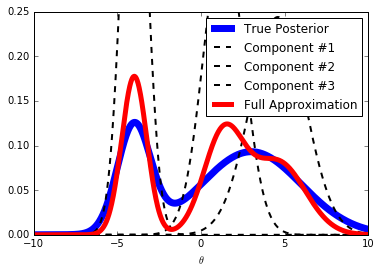

In [30]:
plt.figure()

plt.plot(theta_grid, probs_true, 'b-', linewidth=7, label="True Posterior")

probs_approx = []
for k in range(n_particles):
    probs_approx.append([gaussPdf(z, {'mu':phi_particles[k]['mu'], 'sigma':np.exp(phi_particles[k]['log_sigma'])}) for z in theta_grid]) 
    plt.plot(theta_grid, probs_approx[-1], '--k', linewidth=2, label="Component #%d" %(k+1))
    
full_approx = 1./n_particles * np.array(probs_approx).sum(axis=0)
plt.plot(theta_grid, full_approx, '-r', linewidth=5, label="Full Approximation")

plt.xlabel(r"$\theta$")
plt.xlim([-10,10])
plt.ylim([0,.25])
plt.legend()

plt.show()